In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
# Model
import impl.layer as l

class GRU3:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout

        # Model parameters: weights and biases
        Z = H + D
        m = dict(
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(D / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        #         q = 1-p_dropout
        #         u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
    
    def forward(self, X, h, m):
        Wh, Wy = m['Wh'], m['Wy']
        bh, by = m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()
        
        X = np.column_stack((h_old, X_one_hot))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hz, hz_sigm_cache = l.sigmoid_forward(hh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_old + hz * (hh - h_old)
        y, y_cache = l.fc_forward(h, Wy, by)

        cache = h_old, X_one_hot, hh_cache, hz, hz_sigm_cache, hh, hh_tanh_cache, y_cache

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_old, X_one_hot, hh_cache, hz, hz_sigm_cache, hh, hh_tanh_cache, y_cache = cache
        dh_next = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dh_old1 = (1. - hz) * dh

        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)

        dhz = (hh - h_old) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)

        dhh += dhz
        dX, dWh, dbh = l.fc_backward(dhh, hh_cache)
        dh_old2 = dX[:, :self.H]

        dh = dh_old1 + dh_old2
        dX = dX[:, self.H:]

        grad = dict(Wh=dWh, Wy=dWy, bh=dbh, by=dby)
        
        return dX, dh, grad
        
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[layer])
                caches[layer].append(cache)
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t])
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer])
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [8]:
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    #     for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    loss = np.log(len(set(X_train)))
    smooth_loss = 1.0 #-np.log(1.0 / len(set(X_train)))
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    eps = 1e-8 # impl.constant
    #     idx = 0

    for iter in range(1, n_iter + 1):

        #         if idx >= len(minibatches):
        #             idx = 0
        #             state = nn.initial_state()
        #         X_mini, y_mini = minibatches[idx]
        #         idx += 1
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items in dict={}
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100)
            print(sample)
            
    return nn

Iter-1 loss: 41.9971
ila1t appalnt the euoeetdgar du tudohae uo2ton f 4tps 5b bun ya hodt8 dindpI"ton snmwaorn indtoey tol
Iter-2 loss: 39.6459
iin s0 b1mAofS. Gytruroy wina il lwti sarunhtt ont Win win in yan mapo nte 1xass th rmannt okorty hic
Iter-3 loss: 39.3778
ian the a c1onk robd in th fataisedun pancithw ontan tit ary d unpeNitf wopnnwsErgls of moprt wef xka
Iter-4 loss: 39.2517
ino.vd img an tha band tounte sfepen iof Japann itv aglnthe byxuste-nxont pam in wof tyry reatly io n
Iter-5 loss: 39.0371
in the che 6odurby . fitgy bithe s ond Norldes an mekomes wag woun inpte ank ma th n8 2b hom lud of f
Iter-6 loss: 38.7853
it in the and vid inth f olitour. Anpond om t on alody pour as the an ee in emp inseStan tar an, the 
Iter-7 loss: 38.5247
ion-Japan pan pan e pio the an so dhemo plitome pentan in ald fisof tho th uana lowaved uronkena in g
Iter-8 loss: 38.2629
inext angs and candye pandet ef mest unrtwin sitonlt, en, tis 0lamnvin the im mory ist finol, th rasa
Iter-9 loss: 38.

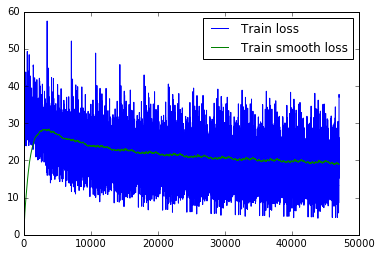

In [6]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 13 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU3(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-13000 loss: 26.8514
 t he,rsr hhh hNhgd ut.kmprhc Kondys nn4  f agpt bisn  in2 lnw jin Gnrp dsi siinni9 aT Lnwsi in oAfhJ
Iter-26000 loss: 26.7060
 ard m3c EhehEhh  0 hmkeu2 h  witnm teloh  Jhheg  ih  ileledI7  ln hhee Pm etcistt    eh h  hOhh e hh
Iter-39000 loss: 17.9109
e. flr. avpelee oemeetr psnfissiettes tsin. et eyan astin. ii tihedtd tfcndd hay  teiet 2 inn eoeer e
Iter-52000 loss: 11.7981
tiexs Itngatn tmonr. .alptwkiylpdbmiey in,  ininy cyLsyyny Agkiyy, aiiiiiitittt., enpppecreccedseou g
Iter-65000 loss: 14.4125
ainldvd.. )Tt omlir  in oflitintiinitinn t eiorgg sitgtreiitroollais etassa cauurtcf of, minctitind  
Iter-78000 loss: 28.2250
areeds fhksearpoI n fnnmpiuCth;s, o Isufnts teoonNtCettttnntttnnndaaanaiiletees sbauelscsteeeeed. fme
Iter-91000 loss: 10.4461
alget ot encenenurt.. tinand Ctanaaneadae asess sburiin i on isit int iileirsdtuandmeeoegdlgg, i cexa
Iter-104000 loss: 14.3768
llecedy ellninpdn elalxtentueepeeos eea eeeauteneeeonI 3n ioebby 2papeulpar alnGorooo

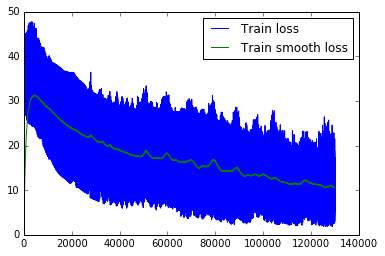

In [36]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 5 # depth
n_iter = 130000 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU3(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

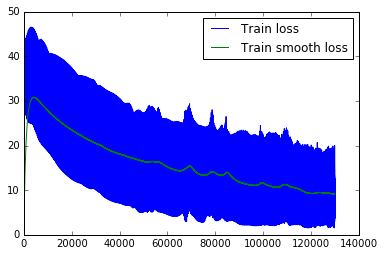

In [35]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

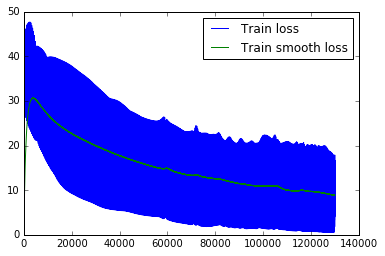

In [33]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

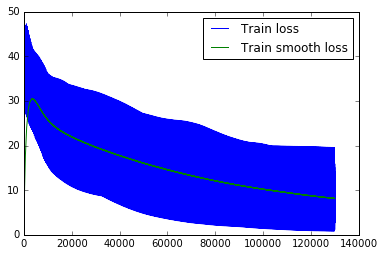

In [31]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

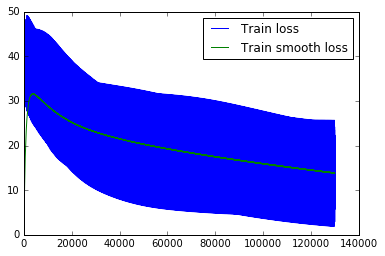

In [29]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

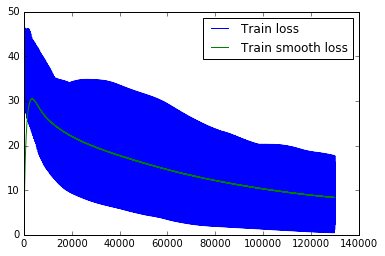

In [24]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

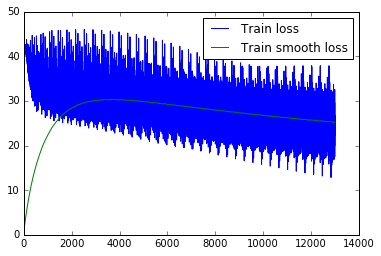

In [22]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()